# Crokinole Score Detection System - Project Notebook

**Project Objective:** Build a web/CLI app that reads a photo of a finished crokinole round and outputs each player's score.

**Target Accuracy:** 95% match with human scoring on held-out test set.

---

## Project Overview

### Game Rules Summary
- **Ring Scoring:** 5, 10, 15 points for outer, middle, inner rings
- **Center (20 points):** Only if disc is completely in hole and flat (removed during play)
- **Line Touch Rule:** Disc touching a ring line gets the lower value
- **Out of Bounds:** On or beyond outer line = 0 points
- **Scoring Modes:** Cancellation scoring + Tournament round points (2-0, 1-1, etc.)

### Pipeline Overview
1. Pre-process image (colour balance, contrast, glare reduction)
2. Detect outer and inner circles and validate board (validate as crokinole board or reject)
3. Perspective correction (straighten to orthogonal view)
4. Semantic segmentation (detect scoring regions)
5. Object detection (find discs as circles)
6. Colour grouping (split into two teams)
7. Score calculation (apply game rules)
8. User input for 20s (removed discs)
9. Output results with overlay visualization

---

## Setup and Configuration

### Import Required Libraries
Import all necessary libraries for image processing, visualization, and data handling.

In [23]:
# Core imports for the entire project
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, util, color, feature, transform, draw, filters, morphology
import json
import os
from pathlib import Path
import Crokinole as crk

### Configuration Parameters
Define all system parameters, thresholds, and settings. Lock these before running on held-out test set.

In [24]:
# Configuration dictionary - LOCK BEFORE HELD-OUT TEST SET
CONFIG = {
    # Pre-processing parameters
    'colour_balance': True,
    'contrast_boost': 1.2,
    'glare_reduction': True,
    
    # Board detection parameters
    'board_detection': {
        'min_circle_ratio': 0.3,  # Min ratio of image size
        'max_circle_ratio': 0.9,  # Max ratio of image size
        'radius_step': 10,        # Step size for radius search
        'canny_low_threshold': 0.1,   # Canny edge detection low threshold
        'canny_high_threshold': 0.2,  # Canny edge detection high threshold
        'edge_sigma': 2,
        'hough_threshold': 0.5
    },
    
    # Ring detection parameters (ratios of outer ring radius)
    'ring_ratios': {
        'outer': 1.0,      # Outer line (boundary for 5pt ring)
        'ring_15': 0.66,   # Inner ring (15pt region)
        'ring_10': 0.33,   # Middle ring (10pt region)
        'ring_5': 0.95,    # Line between 5pt and 10pt regions
        'center': 0.05    # Center hole (20pt - if flat and fully in)
    },
    
    # Ring search parameters
    'ring_search': {
        'tolerance': 0.1,          # ±10% tolerance for expected radius
        'step_size': 2,            # Step size for ring radius search
        'max_center_offset': 0.2,  # Max offset from board center (ratio of board radius)
        'top_peaks': 5             # Number of top peaks to consider per ring
    },
    
    # Board validation parameters
    'board_validation': {
        'min_rings_required': 4     # Minimum rings needed for validation (out of 5 total)
    },
    
    # Disc detection parameters
    'disc_detection': {
        'min_radius_ratio': 0.02,  # Ratio of min image dimension
        'max_radius_ratio': 0.06,  # Ratio of min image dimension
        'max_discs': 28,           # Maximum discs per board (2 teams × 12 + extras)
        'strict_threshold': 0.6,   # Strict pass threshold
        'fallback_threshold': 0.4, # Fallback pass threshold
        'min_disc_spacing': 0.6    # Minimum spacing between disc centers (ratio of radius)
    },
    
    # Colour grouping parameters
    'colour_grouping': {
        'n_clusters': 2,           # Two teams
        'similarity_threshold': 0.3, # If below this, ask user for confirmation
    },
    
    # Paths
    'data_path': 'images/',
    'results_path': 'results/',
    'calibration_split': 0.7,  # 70% calibration, 30% held-out
}

print("Configuration loaded successfully")

Configuration loaded successfully


---

## STEP 1: Image Pre-processing

**Goal:** Improve photo quality so lines and discs are clearer.

**Tasks:**
- Colour balancing to neutralize tint
- Gentle contrast boost for clearer edges
- Reduce small glares
- Prepare image for board detection

**Implementation notes:** Use histogram equalization or white balance algorithms. Apply mild gaussian blur for glare reduction?

### 1.1: Load Test Image

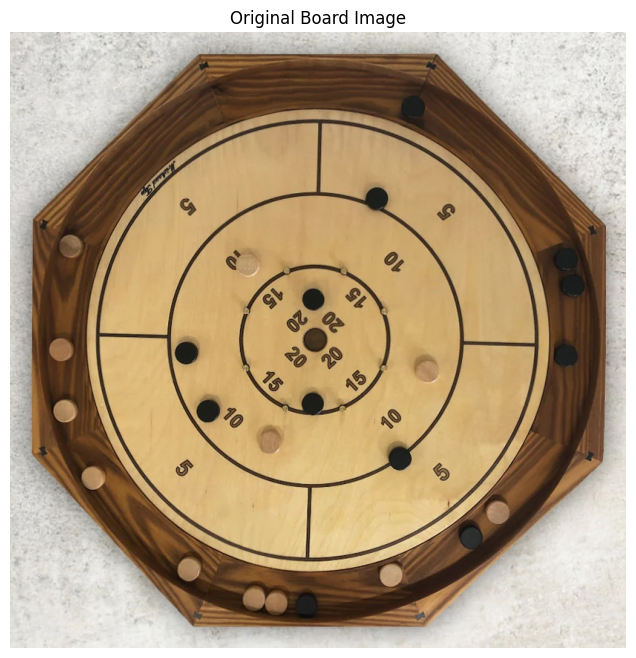

In [25]:
img = io.imread('images/board.jpg')
crk.display_image(img, title="Original Board Image")

### 1.2: Apply Colour Balancing

In [26]:
# TODO: Implement colour balancing
# def balance_colours(image):
#     # Apply white balance or histogram equalization
#     pass

# balanced_img = balance_colours(img)
# Display before/after

### 1.3: Apply Contrast Enhancement

In [27]:
# TODO: Implement contrast boost
# def enhance_contrast(image, factor=1.2):
#     # Apply local or global contrast enhancement
#     pass

# contrasted_img = enhance_contrast(balanced_img, CONFIG['contrast_boost'])
# Display result

### 1.4: Reduce Glare

In [28]:
# TODO: Implement glare reduction
# def reduce_glare(image):
#     # Apply morphological operations or bilateral filtering
#     pass

# preprocessed_img = reduce_glare(contrasted_img)
# Display final preprocessed image

---

## STEP 2: Board Detection and Validation

**Goal:** Detect the crokinole board and validate the image as a valid board, or reject it.

**Tasks:**
- Find large outer circle (board boundary)
- Detect inner ring pattern
- Verify ring spacing ratios match crokinole board
- Reject if pattern unclear or doesn't match

**Implementation notes:** Use Hough Circle Transform for outer circle. Check for concentric rings at expected ratios. Pattern check along radial lines from center.

### 2.1: Edge Detection for Board Finding

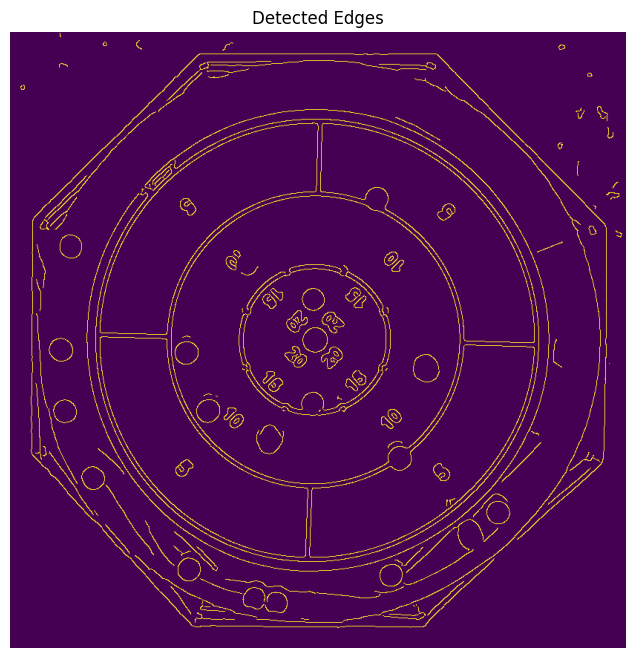

In [29]:
# Detect edges using Canny edge detection
edges = crk.detect_edges(img, CONFIG)

# Visualize edges
crk.display_image(edges, title="Detected Edges", figsize=(8, 8))

### 2.2: Detect Board and Rings (Outer Circle + Inner Rings)

Board detected: center=(412, 413), radius=309
Detected 5 rings: ['outer', 'ring_5', 'ring_15', 'ring_10', 'center']

VALID BOARD - 5/5 rings detected (confidence: 1.00)


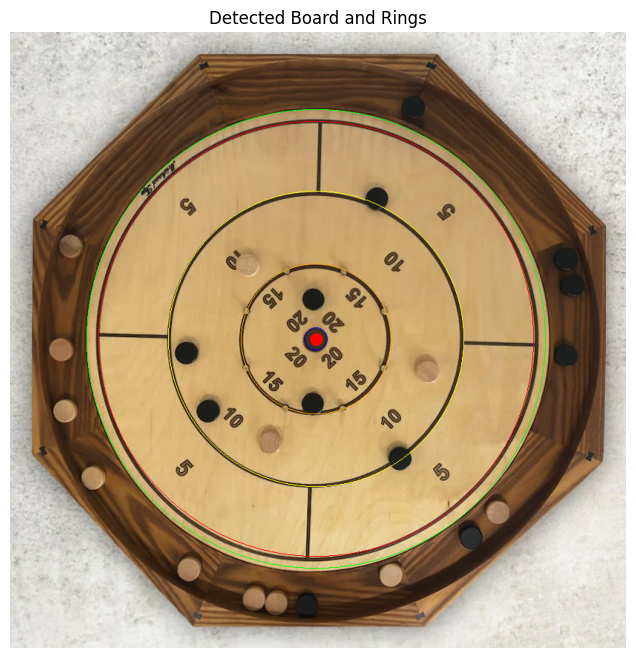

In [30]:
board_result = crk.detect_board_and_rings(edges, CONFIG)

if board_result is not None:
    board_center = board_result['center']
    board_radius = board_result['radius']
    detected_rings = board_result['rings']
    
    print(f"Board detected: center={board_center}, radius={board_radius}")
    print(f"Detected {len(detected_rings)} rings: {list(detected_rings.keys())}")
    
    # Validation: Check if we found enough rings
    min_rings = CONFIG['board_validation']['min_rings_required']
    confidence = len(detected_rings) / 5  # Out of 5 expected rings
    
    if len(detected_rings) >= min_rings:
        print(f"\nVALID BOARD - {len(detected_rings)}/5 rings detected (confidence: {confidence:.2f})")
    else:
        print(f"\nWARNING: Only {len(detected_rings)}/5 rings detected (below minimum of {min_rings})")
    
    crk.visualize_board_detection(img, board_result)
else:
    board_center = None
    board_radius = None
    detected_rings = None
    print("REJECTED: Not a valid crokinole board - could not detect ring pattern")

---

## STEP 3: Perspective Correction

**Goal:** Straighten the board image to orthogonal (top-down) view.

**Tasks:**
- Detect perspective distortion
- Apply homography transformation
- Warp image to standardized orthogonal view
- Ensure rings remain circular after correction

**Implementation notes:** Use detected board circle and rings to compute homography. May need to detect 4 corner points or use circle ellipse fitting for perspective estimation.

### 3.1: Correct Perspective Distortion

Register detected rings (ellipses due to perspective) to perfect circles using homography.

Perspective correction computed from 250 point correspondences

No significant transformation needed (image already orthogonal)


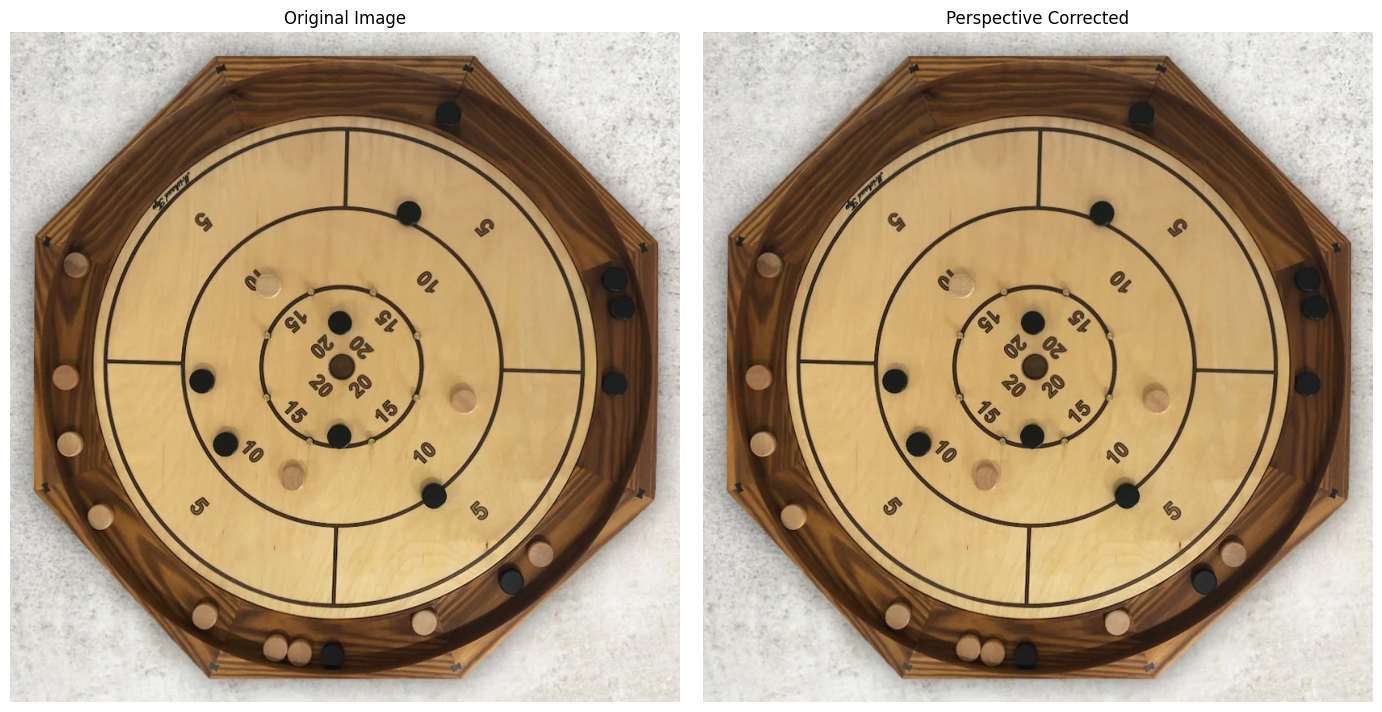

In [31]:
if board_result is not None:
    # Correct perspective by mapping detected rings to perfect circles
    straightened_img, transform_info = crk.correct_perspective(img, board_result)
    
    if straightened_img is not None:
        # Display transformation information
        crk.display_transform_info(transform_info, len(detected_rings))
        
        # Display before/after comparison
        crk.display_images(
            [img, straightened_img],
            titles=['Original Image', 'Perspective Corrected']
        )
    else:
        straightened_img = img
        print("Could not compute perspective correction, using original image")
else:
    straightened_img = img
    print("No board detected, skipping perspective correction")

---

## STEP 4: Semantic Segmentation - Scoring Regions

**Goal:** Map the scoring regions (rings) on the straightened board image.

**Tasks:**
- Use detected rings to define scoring region boundaries
- Create segmentation mask with regions: center (20), inner (15), middle (10), outer (5), outside (0)
- Handle line-touch rule: disc touching line gets lower value
- Visualize segmentation overlay

**Implementation notes:** Use ring radii from detection. Create labeled regions. Consider buffer zones at ring boundaries for line-touch detection.

### 4.1: Create Scoring Region Mask

In [ ]:
if board_result is not None:
    scoring_mask = crk.create_scoring_regions(straightened_img.shape, board_result)
    print(f"Scoring regions created: {np.unique(scoring_mask)}")
    print(f"Mask shape: {scoring_mask.shape}")
else:
    scoring_mask = None
    print("No board detected, cannot create scoring regions")

### 4.2: Visualize Scoring Regions

In [ ]:
if scoring_mask is not None:
    crk.visualize_scoring_regions(straightened_img, scoring_mask)
else:
    print("No scoring mask available to visualize")

---

## STEP 5: Disc Detection (Object Detection)

**Goal:** Find all crokinole discs on the board.

**Tasks:**
- Detect small circles (discs) within expected size range
- Use two-pass strategy: strict pass first, fallback if needed
- Filter duplicates and ensure minimum spacing
- Limit to maximum 28 discs (12 per team + extras)
- Mask detection to board area only

### 5.1: Detect Discs using Hough Circle Transform

In [34]:
# TODO: Implement disc detection using Hough Circle Transform
# Detect discs on straightened board image
# Use CONFIG['disc_detection'] parameters
# Filter duplicates and ensure minimum spacing between discs
# Return list of detected disc positions and radii

### 5.2: Fallback Detection (if needed)

In [35]:
# TODO: Fallback detection with looser parameters if needed
# If strict pass finds too few discs (< 5), retry with fallback threshold
# Merge results and filter duplicates
# Limit to maximum CONFIG['disc_detection']['max_discs'] (28)

---

## STEP 6: Colour Grouping (Team Assignment)

**Goal:** Split detected discs into two teams based on colour.

**Tasks:**
- Extract colour from each disc region
- Use clustering (k-means, k=2) to group into two teams
- Handle edge cases: similar colours, uncertain assignments
- Flag low-confidence assignments for user verification

**Implementation notes:** Sample colour from disc center. Use HSV or LAB colour space. Calculate colour similarity score between teams.

### 6.1: Extract Disc Colours

In [36]:
# TODO: Extract colour features from each detected disc
# def extract_disc_colours(image, detected_discs):
#     # For each disc, sample colour from center region
#     # Convert to appropriate colour space (HSV or LAB)
#     # Return array of colour features
#     pass

# disc_colours = extract_disc_colours(straightened_img, detected_discs)
# print(f"Extracted colours for {len(disc_colours)} discs")

### 6.2: Cluster into Two Teams

In [37]:
# TODO: Use k-means clustering to assign discs to teams
# from sklearn.cluster import KMeans

# def cluster_teams(disc_colours, n_clusters=2):
#     # Apply k-means clustering
#     # Return team assignments (0 or 1) for each disc
#     pass

# team_assignments = cluster_teams(disc_colours, CONFIG['colour_grouping']['n_clusters'])
# print(f"Team 1: {np.sum(team_assignments == 0)} discs")
# print(f"Team 2: {np.sum(team_assignments == 1)} discs")

### 6.3: Check Colour Similarity and Flag Uncertain Assignments

In [38]:
# TODO: Calculate colour similarity between teams
# def check_colour_similarity(disc_colours, team_assignments):
#     # Calculate average colour for each team
#     # Compute colour distance between teams
#     # Flag if teams are too similar
#     # Return similarity score and uncertain discs list
#     pass

# similarity, uncertain_discs = check_colour_similarity(disc_colours, team_assignments)
# if similarity < CONFIG['colour_grouping']['similarity_threshold']:
#     print(f"⚠️  Team colours are similar (score: {similarity:.2f})")
#     print(f"   {len(uncertain_discs)} discs flagged for user verification")
# else:
#     print(f"✓ Team colours are distinct (score: {similarity:.2f})")

---

## STEP 7: Score Calculation (Apply Game Rules)

**Goal:** Calculate score for each disc based on its position and game rules.

**Tasks:**
- For each disc, determine which scoring region it occupies
- Apply line-touch rule: if disc touches boundary, give lower value
- Handle center hole (20pt): only if disc fully inside and flat
- Assign 0 points to discs outside outer boundary
- Flag edge cases for review (overlapping discs, disc on peg, uncertain position)

**Implementation notes:** Use scoring mask from Step 4. Sample multiple points around disc perimeter to detect line touches. Use disc radius to check if fully within center hole.

### 7.1: Assign Score to Each Disc

In [39]:
# TODO: Calculate score for each disc based on position and game rules
# def calculate_disc_scores(detected_discs, scoring_mask, board_circle):
#     # For each disc:
#     #   1. Sample points around disc perimeter
#     #   2. Check scoring regions at those points
#     #   3. If multiple regions detected, apply line-touch rule (lower value)
#     #   4. Check if fully in center hole for 20pt (else 15pt if in center region)
#     #   5. Flag uncertain cases (on peg, overlapping, very close to line)
#     # Return: list of (disc_idx, score, confidence, flags)
#     pass

# disc_scores = calculate_disc_scores(detected_discs, scoring_mask, board_circle)
# for i, (disc_idx, score, confidence, flags) in enumerate(disc_scores):
#     status = "⚠️" if flags else "✓"
#     print(f"{status} Disc {i}: {score}pts (confidence: {confidence:.2f})")

### 7.2: Calculate Team Totals (Visible Discs Only)

In [40]:
# TODO: Sum scores by team (excluding 20s, which are removed during play)
# def calculate_team_totals(disc_scores, team_assignments):
#     # Sum scores for team 0 and team 1
#     # Exclude any 20pt scores (those are handled separately)
#     # Return (team1_total, team2_total)
#     pass

# team1_visible, team2_visible = calculate_team_totals(disc_scores, team_assignments)
# print(f"Team 1 (visible discs): {team1_visible} pts")
# print(f"Team 2 (visible discs): {team2_visible} pts")
# print("\n⚠️  Note: 20-point scores not included yet (see next step)")

---

## STEP 8: User Input for 20-Point Discs

**Goal:** Get count of 20-point discs for each player (removed during play).

**Tasks:**
- Prompt user for Team 1's count of 20-point discs
- Prompt user for Team 2's count of 20-point discs
- Validate input (reasonable range, e.g., 0-12 per team)
- Add 20×count to each team's total

**Implementation notes:** In final app, this will be CLI/web form input. For notebook testing, use Python input() or hardcode test values.

### 8.1: Get User Input for 20-Point Counts

In [41]:
# TODO: Get 20-point counts from user
# For notebook testing, hardcode values or use input()
# In final app, this will be CLI/web form input
# Validate input (reasonable range: 0-12 per team)

### 8.2: Calculate Final Totals

In [42]:
# TODO: Calculate final scores including 20s
# Add 20-point counts to visible disc totals
# Display final scores for both teams

---

## STEP 9: Output Results

**Goal:** Generate final output with visualization and data export.

**Tasks:**
- Create overlay image showing:
  - Detected board and rings
  - All detected discs with outlines
  - Team colour coding
  - Per-disc point values
  - Final totals
- Calculate cancellation scoring
- Calculate tournament round points (if selected)
- Export results to JSON/CSV file
- Save overlay image

**Implementation notes:** Use matplotlib for overlay. Create results dictionary with all metadata. Save to structured JSON format.

### 9.1: Create Visualization Overlay

In [43]:
# TODO: Create comprehensive visualization overlay
# def create_results_overlay(image, board_circle, detected_rings, detected_discs, 
#                            team_assignments, disc_scores):
#     # Draw rings
#     # Draw disc outlines with team colours
#     # Add score labels on each disc
#     # Add totals legend
#     # Highlight uncertain discs with special marker
#     pass

# overlay_img = create_results_overlay(
#     straightened_img, board_circle, detected_rings, 
#     detected_discs, team_assignments, disc_scores
# )

# fig, ax = plt.subplots(1, figsize=(12, 12))
# ax.imshow(overlay_img)
# ax.set_title(f'Crokinole Score Detection - Team 1: {team1_final}pts | Team 2: {team2_final}pts')
# ax.axis('off')
# plt.show()

### 9.2: Calculate Cancellation Scoring

In [44]:
# Calculate cancellation scoring (difference only)
cancellation_score = abs(team1_final - team2_final)
winner = "Team 1" if team1_final > team2_final else "Team 2" if team2_final > team1_final else "Tie"

print(f"\nCANCELLATION SCORING:")
print(f"Winner: {winner}")
print(f"Margin: {cancellation_score} pts")

NameError: name 'team1_final' is not defined

### 9.3: Calculate Tournament Round Points (Optional)

In [ ]:
# TODO: Calculate tournament round points based on standard rules
# tournament_mode = True  # Set to True if using tournament mode

# def calculate_tournament_points(team1_score, team2_score):
#     # Apply tournament round-points rules
#     # Return format like "2-0", "1-1", etc.
#     pass

# if tournament_mode:
#     tournament_result = calculate_tournament_points(team1_final, team2_final)
#     print(f"\nTOURNAMENT ROUND POINTS: {tournament_result}")

### 9.4: Export Results to JSON/CSV

In [ ]:
# TODO: Create results dictionary and export
# results = {
#     'metadata': {
#         'timestamp': str(datetime.now()),
#         'image_path': 'images/board.jpg',
#         'config_locked': False  # Set True after calibration
#     },
#     'board_detection': {
#         'valid': True,
#         'confidence': confidence,
#         'center': board_circle['center'],
#         'radius': board_circle['radius']
#     },
#     'disc_detection': {
#         'total_discs': len(detected_discs),
#         'team1_discs': np.sum(team_assignments == 0),
#         'team2_discs': np.sum(team_assignments == 1),
#         'uncertain_discs': len(uncertain_discs)
#     },
#     'scores': {
#         'team1': {
#             'visible': team1_visible,
#             'twenties': team1_20s * 20,
#             'total': team1_final
#         },
#         'team2': {
#             'visible': team2_visible,
#             'twenties': team2_20s * 20,
#             'total': team2_final
#         },
#         'cancellation': {
#             'winner': winner,
#             'margin': cancellation_score
#         }
#     }
# }

# # Save to JSON
# output_path = Path(CONFIG['results_path'])
# output_path.mkdir(exist_ok=True)
# with open(output_path / 'results.json', 'w') as f:
#     json.dump(results, f, indent=2)

# print(f"\n✓ Results exported to {output_path / 'results.json'}")

### 9.5: Save Overlay Image

In [ ]:
# TODO: Save overlay image to results folder
# overlay_output_path = output_path / 'overlay_result.png'
# io.imsave(overlay_output_path, overlay_img)
# print(f"✓ Overlay image saved to {overlay_output_path}")

---

## STEP 10: Evaluation and Testing

**Goal:** Implement evaluation metrics and testing framework for the system.

**Tasks:**
- Implement detection score metric
- Test on calibration split (70% of data)
- Measure disc detection accuracy
- Test ring assignment accuracy  
- Validate final score accuracy
- Test robustness across conditions
- Test non-board rejection rate

**Implementation notes:** Use formulas from proposal. Track metrics per photo. Generate summary statistics and plots.

### 10.1: Detection Score Metric
Formula: `2 × correct / (2 × correct + missed + extras)`

In [ ]:
# TODO: Implement detection score calculation
# def calculate_detection_score(detected, ground_truth, match_threshold=5):
#     """
#     Calculate detection score based on proposal formula.
#     
#     Args:
#         detected: List of detected disc positions [(x,y), ...]
#         ground_truth: List of actual disc positions [(x,y), ...]
#         match_threshold: Max distance in pixels to consider a match
#     
#     Returns:
#         score: Detection score (0 to 1)
#         correct: Number of correct detections
#         missed: Number of missed discs
#         extras: Number of false detections
#     """
#     # Match detected to ground truth
#     # Count correct, missed, extras
#     # Apply formula: 2 × correct / (2 × correct + missed + extras)
#     pass

# Example usage (with ground truth labels)
# ground_truth_discs = []  # Load from labels
# detection_score, correct, missed, extras = calculate_detection_score(
#     detected_discs, ground_truth_discs
# )
# print(f"Detection Score: {detection_score:.3f}")
# print(f"  Correct: {correct}, Missed: {missed}, Extras: {extras}")

### 10.2: Ring Assignment Accuracy

In [ ]:
# TODO: Test ring assignment accuracy
# def evaluate_ring_accuracy(predicted_scores, ground_truth_scores):
#     """
#     Check if each disc was assigned to the correct ring.
#     Separately track near-line cases (within threshold of boundary).
#     """
#     # Compare predicted vs ground truth scores
#     # Calculate accuracy overall and for near-line cases
#     pass

# Example usage
# ring_accuracy, near_line_accuracy = evaluate_ring_accuracy(
#     disc_scores, ground_truth_scores
# )
# print(f"Ring Assignment Accuracy: {ring_accuracy:.1%}")
# print(f"Near-line Cases Accuracy: {near_line_accuracy:.1%}")

### 10.3: Final Score Accuracy

In [ ]:
# TODO: Check if final scores match human scoring
# def evaluate_final_scores(predicted_totals, ground_truth_totals):
#     """
#     Check if both teams' totals match exactly.
#     Report average mismatch size when not exact.
#     """
#     # Compare (team1_pred, team2_pred) vs (team1_truth, team2_truth)
#     # Calculate exact match rate and average error
#     pass

# Example usage
# exact_match_rate, avg_error = evaluate_final_scores(
#     (team1_final, team2_final), 
#     (ground_truth_team1, ground_truth_team2)
# )
# print(f"Exact Match Rate: {exact_match_rate:.1%}")
# print(f"Average Error (when mismatched): {avg_error:.1f} pts")

### 10.4: Robustness Testing

In [ ]:
# TODO: Test robustness across different conditions
# def test_robustness(test_dataset):
#     """
#     Test across:
#     - Photo angles (orthogonal to oblique)
#     - Lighting conditions
#     - Board styles
#     - Disc colours
#     
#     Generate breakdown plots showing performance per condition.
#     """
#     # Group results by condition
#     # Calculate metrics for each group
#     # Generate comparison plots
#     pass

# robustness_results = test_robustness(calibration_dataset)
# # Generate plots: accuracy vs angle, accuracy vs lighting, etc.

### 10.5: Non-Board Rejection Test

In [ ]:
# TODO: Test rejection of non-crokinole images
# def test_non_board_rejection(non_board_images):
#     """
#     Test 30 non-crokinole round objects.
#     Count how many are correctly rejected.
#     """
#     # Run board detection on each image
#     # Count rejections vs false acceptances
#     pass

# rejection_rate = test_non_board_rejection(non_board_dataset)
# print(f"Non-board Rejection Rate: {rejection_rate:.1%}")
# print(f"Target: >95% rejection")

---

## STEP 11: Data Collection and Labeling

**Goal:** Build comprehensive dataset for calibration and testing.

**Target:** 120 total photos
- 90 crokinole photos (various boards, lighting, angles)
- 30 non-crokinole round objects (for rejection testing)

**Split:** 70% calibration, 30% held-out test set

**Tasks:**
- Capture photos across different conditions
- Create labeling tool for marking disc centers, sizes, rings, and teams
- Record ring-ratio template for each board style
- Organize dataset with metadata
- Document photo capture guidelines

### 11.1: Dataset Organization

In [ ]:
# TODO: Create dataset directory structure
# dataset/
#   calibration/  (70% - 63 crokinole + 21 non-board)
#     crokinole/
#       board_A/
#       board_B/
#       ...
#     non_board/
#   test/  (30% - 27 crokinole + 9 non-board)
#     crokinole/
#     non_board/
#   labels/
#     calibration/
#     test/
#   metadata/
#     board_templates.json  # Ring ratios for each board

# Create directories
# dataset_structure = {
#     'calibration': ['crokinole/board_A', 'crokinole/board_B', 'non_board'],
#     'test': ['crokinole', 'non_board'],
#     'labels': ['calibration', 'test'],
#     'metadata': []
# }

### 11.2: Simple Labeling Tool

In [ ]:
# TODO: Create interactive labeling tool
# def label_image_interactive(image_path):
#     """
#     Interactive tool for labeling:
#     - Click to mark disc centers
#     - Input disc radius
#     - Assign team (0 or 1)
#     - Assign ring value (0, 5, 10, 15, 20)
#     - Save labels to JSON
#     """
#     # Use matplotlib event handlers for clicking
#     # Store labels in structured format
#     pass

# Label format:
# {
#   "image": "path/to/image.jpg",
#   "board": {"center": [x, y], "radius": r},
#   "discs": [
#     {"center": [x, y], "radius": r, "team": 0, "ring": 10},
#     ...
#   ],
#   "team1_20s": 2,
#   "team2_20s": 1
# }

---

## STEP 12: Application Development (CLI/Web)

**Goal:** Package the system into a usable application.

**Tasks:**
- Create command-line interface (CLI) for batch processing
- Build simple web upload interface (optional)
- Implement folder processing with progress reporting
- Add user confirmations for uncertain cases
- Create user manual with photo guidelines
- Package for easy deployment

**Implementation notes:** Use argparse for CLI. Flask/Streamlit for web interface. Add logging and error handling.

### 12.1: CLI Skeleton

In [ ]:
# TODO: Design CLI interface structure
# 
# Example usage:
# python crokinole_scorer.py --input images/round1.jpg --output results/
# python crokinole_scorer.py --batch images/folder/ --output results/
#
# Arguments:
#   --input: Single image or folder
#   --output: Output directory
#   --config: Path to config file (optional, uses defaults)
#   --interactive: Enable user confirmations for uncertain cases
#   --tournament: Enable tournament mode
#
# This will be implemented as a separate Python script, not in notebook

---

## Project Timeline & Milestones

**Week 1:** Board finder, ring detection, validation, accept/reject preview  
**Week 2:** Perspective correction, ring overlay, capture calibration photos  
**Week 3:** Disc finder with masking and two-pass strategy, labeling tool  
**Week 4:** Colour grouping, ring value logic, line-touch rule, 20s input  
**Week 5:** Run calibration studies, generate figures/tables, lock settings  
**Week 6:** Held-out test set evaluation, robustness analysis, results writeup  
**Week 7:** Finalize report and slides, optional improvements, rehearse presentation

---

## Next Steps

1. **Start with Step 1-2:** Implement pre-processing and board detection
2. **Test on sample images:** Use your existing `board.jpg` to validate each step
3. **Iterate:** Tune parameters as you go
4. **Document:** Keep notes on what works and what doesn't
5. **Collect data:** Start capturing photos early (Week 2)
6. **Lock settings:** Before running on held-out set (Week 5)

**Remember:** This is an iterative process. Start simple, test frequently, and refine based on results!